# SEO Content Quality Analysis Pipeline

This notebook implements a complete machine learning pipeline for:
- Parsing HTML content and extracting clean text
- Engineering NLP features (readability, keywords, embeddings)
- Detecting duplicate/similar content
- Scoring content quality with ML models
- Real-time analysis of new URLs

## 1. Setup and Imports

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import csv
import sys
import warnings
import pickle
import json
from pathlib import Path

# HTML parsing
from bs4 import BeautifulSoup
import requests

# NLP and text processing
import re
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

# ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Increase CSV field size limit for large HTML content
csv.field_size_limit(sys.maxsize)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Data Collection & HTML Parsing 

Parse HTML content from the provided dataset and extract clean text.

In [2]:
def parse_html_content(html_content):
    try:
        soup = BeautifulSoup(html_content, 'lxml')
        
        # Extract title
        title_tag = soup.find('title')
        title = title_tag.get_text().strip() if title_tag else ''
        
        # Remove script and style elements
        for script in soup(["script", "style", "noscript", "header", "footer", "nav"]):
            script.decompose()
        
        # Extract text from main content areas
        # Priority: article > main > body > all text
        main_content = soup.find('article') or soup.find('main') or soup.find('body') or soup
        
        # Get text and clean it
        text = main_content.get_text(separator=' ', strip=True)
        
        # Clean whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Calculate word count
        word_count = len(text.split())
        
        return {
            'title': title,
            'body_text': text,
            'word_count': word_count
        }
    
    except Exception as e:
        print(f"Error parsing HTML: {str(e)}")
        return {
            'title': '',
            'body_text': '',
            'word_count': 0
        }


In [3]:
# Load the dataset
data_path = '../seo-content-detector/data/data.csv'
df = pd.read_csv(data_path)

print(f"Dataset loaded: {len(df)} rows")
print(f"Columns: {df.columns.tolist()}")
df.head(2)

Dataset loaded: 81 rows
Columns: ['url', 'html_content']


,url,html_content
0,https://www.cm-alliance.com/cybersecurity-blog,"<!doctype html><!--[if lt IE 7]> <html class=""..."
1,https://www.varonis.com/blog/cybersecurity-tips,"<!doctype html><html lang=""en""><head>\n <me..."


In [4]:
# Parse HTML content for all rows
print("Parsing HTML content...")

parsed_data = []
errors = 0

for idx, row in df.iterrows():
    try:
        parsed = parse_html_content(row['html_content'])
        parsed_data.append({
            'url': row['url'],
            'title': parsed['title'],
            'body_text': parsed['body_text'],
            'word_count': parsed['word_count']
        })
    except Exception as e:
        errors += 1
        print(f"Error processing row {idx}: {str(e)}")
        parsed_data.append({
            'url': row['url'],
            'title': '',
            'body_text': '',
            'word_count': 0
        })

# Create DataFrame
extracted_df = pd.DataFrame(parsed_data)

print(f"\n✅ Parsing complete!")
print(f"Successfully parsed: {len(extracted_df) - errors} rows")
print(f"Errors: {errors} rows")
print(f"\nWord count statistics:")
print(extracted_df['word_count'].describe())

extracted_df.head()

Parsing HTML content...
Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a byt

,url,title,body_text,word_count
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,Cybersecurity Blog Cybersecurity Measures Ever...,2017
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,Cybersecurity is gaining more importance globa...,1700
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,Home Insights Blog Posts 11 Cyber Defense Tips...,1058
3,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices | Cybersecurity a...,Cybersecurity Best Practices CISA provides inf...,826
4,https://www.qnbtrust.bank/Resources/Learning-C...,,,0


In [5]:
extracted_df

,url,title,body_text,word_count
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,Cybersecurity Blog Cybersecurity Measures Ever...,2017
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,Cybersecurity is gaining more importance globa...,1700
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,Home Insights Blog Posts 11 Cyber Defense Tips...,1058
3,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices | Cybersecurity a...,Cybersecurity Best Practices CISA provides inf...,826
4,https://www.qnbtrust.bank/Resources/Learning-C...,,,0
...,...,...,...,...
76,https://www.cnbc.com/artificial-intelligence/,,,0
77,https://www.bbc.com/news/topics/c404v061z99t,,,0
78,https://www.theguardian.com/technology/artific...,Artificial intelligence (AI) | The Guardian,Artificial intelligence (AI) November 2025 Boo...,275
79,https://apnews.com/hub/artificial-intelligence,Artificial intelligence | AP News,AI song generator Udio offers brief window for...,537


In [6]:
# Save extracted content
output_path = '../seo-content-detector/data/extracted_content.csv'
extracted_df.to_csv(output_path, index=False)
print(f"✅ Extracted content saved to: {output_path}")

✅ Extracted content saved to: ../seo-content-detector/data/extracted_content.csv


## 3. Text Preprocessing & Feature Engineering (25%)

Extract comprehensive features:
- Basic metrics (word count, sentence count)
- Readability scores (Flesch Reading Ease)
- Top keywords (TF-IDF)
- Text embeddings (Sentence Transformers)

In [7]:
def clean_text(text):
    """Clean text for feature extraction."""
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def count_sentences(text):
    """Count sentences in text."""
    sentences = re.split(r'[.!?]+', text)
    return len([s for s in sentences if s.strip()])

def calculate_readability(text):
    """Calculate Flesch Reading Ease score."""
    try:
        # Need at least 100 characters for reliable score
        if len(text) < 100:
            return 0.0
        return textstat.flesch_reading_ease(text)
    except:
        return 0.0

In [8]:
# Extract basic features
print("Extracting basic features...")

extracted_df['clean_text'] = extracted_df['body_text'].apply(clean_text)
extracted_df['sentence_count'] = extracted_df['body_text'].apply(count_sentences)
extracted_df['flesch_reading_ease'] = extracted_df['body_text'].apply(calculate_readability)

extracted_df[['url', 'word_count', 'sentence_count', 'flesch_reading_ease']].head()

Extracting basic features...


,url,word_count,sentence_count,flesch_reading_ease
0,https://www.cm-alliance.com/cybersecurity-blog,2017,110,41.600994
1,https://www.varonis.com/blog/cybersecurity-tips,1700,94,41.465000
2,https://www.cisecurity.org/insights/blog/11-cy...,1058,73,53.262918
3,https://www.cisa.gov/topics/cybersecurity-best...,826,34,-2.538002
4,https://www.qnbtrust.bank/Resources/Learning-C...,0,0,0.000000


In [9]:
# Extract top keywords using TF-IDF
print("Extracting keywords with TF-IDF...")

# Filter out empty texts
valid_texts = extracted_df[extracted_df['word_count'] > 0]['clean_text'].tolist()
valid_indices = extracted_df[extracted_df['word_count'] > 0].index.tolist()

if len(valid_texts) > 0:
    # Create TF-IDF vectorizer
    tfidf = TfidfVectorizer(
        max_features=100,
        stop_words='english',
        ngram_range=(1, 2),
        min_df=2
    )
    
    tfidf_matrix = tfidf.fit_transform(valid_texts)
    feature_names = tfidf.get_feature_names_out()
    
    # Extract top 5 keywords for each document
    top_keywords = []
    for i in range(len(valid_texts)):
        tfidf_scores = tfidf_matrix[i].toarray()[0]
        top_indices = tfidf_scores.argsort()[-5:][::-1]
        keywords = [feature_names[idx] for idx in top_indices if tfidf_scores[idx] > 0]
        top_keywords.append('|'.join(keywords[:5]))
    
    # Add to dataframe
    extracted_df['top_keywords'] = ''
    for idx, keywords in zip(valid_indices, top_keywords):
        extracted_df.at[idx, 'top_keywords'] = keywords
    
    print(f"✅ Keywords extracted for {len(valid_texts)} documents")
else:
    extracted_df['top_keywords'] = ''
    print("⚠️ No valid texts found for keyword extraction")

extracted_df[['url', 'top_keywords']].head()

Extracting keywords with TF-IDF...
✅ Keywords extracted for 68 documents


,url,top_keywords
0,https://www.cm-alliance.com/cybersecurity-blog,2025|october|security|digital|data
1,https://www.varonis.com/blog/cybersecurity-tips,data|access|security|information|ai
2,https://www.cisecurity.org/insights/blog/11-cy...,use|data|work|email|security
3,https://www.cisa.gov/topics/cybersecurity-best...,best|security|2025|software|help
4,https://www.qnbtrust.bank/Resources/Learning-C...,


In [10]:
# Generate embeddings using Sentence Transformers
print("Generating embeddings with Sentence Transformers...")
print("(This may take a few minutes for the first run)\n")

# Load model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for valid texts
embeddings_list = []
for idx, row in extracted_df.iterrows():
    if row['word_count'] > 0:
        # Use first 500 words for efficiency
        text_sample = ' '.join(row['clean_text'].split()[:500])
        embedding = embedding_model.encode(text_sample)
        embeddings_list.append(embedding)
    else:
        # Zero embedding for empty text
        embeddings_list.append(np.zeros(384))  # Model dimension

# Convert to numpy array
embeddings_array = np.array(embeddings_list)

print(f"✅ Generated embeddings with shape: {embeddings_array.shape}")

Generating embeddings with Sentence Transformers...
(This may take a few minutes for the first run)

✅ Generated embeddings with shape: (81, 384)


In [11]:
# Create features DataFrame
features_df = extracted_df[[
    'url', 'word_count', 'sentence_count', 
    'flesch_reading_ease', 'top_keywords'
]].copy()

# Store embeddings as string representation
features_df['embedding'] = [str(emb.tolist()) for emb in embeddings_array]

# Add thin content flag
features_df['is_thin'] = features_df['word_count'] < 500

print(f"✅ Features DataFrame created with {len(features_df)} rows")
print(f"\nFeature summary:")
print(features_df.describe())

features_df.head()

✅ Features DataFrame created with 81 rows

Feature summary:
         word_count  sentence_count  flesch_reading_ease
count     81.000000       81.000000            81.000000
mean    2735.209877      203.827160            29.816184
std     5349.750687      499.328419            25.450945
min        0.000000        0.000000           -18.877819
25%      127.000000        5.000000             9.174535
50%     1058.000000       70.000000            30.623056
75%     3228.000000      191.000000            46.295748
max    36864.000000     3825.000000           103.391996


,url,word_count,sentence_count,flesch_reading_ease,top_keywords,embedding,is_thin
0,https://www.cm-alliance.com/cybersecurity-blog,2017,110,41.600994,2025|october|security|digital|data,"[-0.05104533210396767, -0.014222581870853901, ...",False
1,https://www.varonis.com/blog/cybersecurity-tips,1700,94,41.465000,data|access|security|information|ai,"[-0.02056223712861538, -0.0463375598192215, -0...",False
2,https://www.cisecurity.org/insights/blog/11-cy...,1058,73,53.262918,use|data|work|email|security,"[-0.01513755228370428, 0.017463358119130135, 0...",False
3,https://www.cisa.gov/topics/cybersecurity-best...,826,34,-2.538002,best|security|2025|software|help,"[-0.037591204047203064, 0.026019496843218803, ...",False
4,https://www.qnbtrust.bank/Resources/Learning-C...,0,0,0.000000,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True


In [12]:
# Save features
features_path = '../seo-content-detector/data/features.csv'
features_df.to_csv(features_path, index=False)

## 4. Duplicate Detection (20%)

Detect near-duplicate content using cosine similarity on embeddings.

In [13]:
# Compute pairwise cosine similarity
print("Computing cosine similarity matrix...")

similarity_matrix = cosine_similarity(embeddings_array)

print(f"Similarity matrix computed: {similarity_matrix.shape}")
print(f"\nSimilarity range: [{similarity_matrix.min():.3f}, {similarity_matrix.max():.3f}]")

Computing cosine similarity matrix...
Similarity matrix computed: (81, 81)

Similarity range: [-0.162, 1.000]


In [14]:
# Find duplicate pairs above threshold
SIMILARITY_THRESHOLD = 0.

duplicate_pairs = []

for i in range(len(similarity_matrix)):
    for j in range(i + 1, len(similarity_matrix)):
        similarity = similarity_matrix[i][j]
        if similarity > SIMILARITY_THRESHOLD:
            duplicate_pairs.append({
                'url1': features_df.iloc[i]['url'],
                'url2': features_df.iloc[j]['url'],
                'similarity': round(similarity, 3)
            })

# Create duplicates DataFrame
duplicates_df = pd.DataFrame(duplicate_pairs)

# Sort by similarity (highest first)
if len(duplicates_df) > 0:
    duplicates_df = duplicates_df.sort_values('similarity', ascending=False)

print(f"\n📊 Duplicate Detection Results:")
print(f"Similarity threshold: {SIMILARITY_THRESHOLD}")
print(f"Duplicate pairs found: {len(duplicates_df)}")

if len(duplicates_df) > 0:
    print(f"\nTop duplicate pairs:")
    print(duplicates_df.head(10))
else:
    print("\nNo duplicate pairs found above threshold.")


📊 Duplicate Detection Results:
Similarity threshold: 0.9
Duplicate pairs found: 1

Top duplicate pairs:
                                                url1  \
0  https://en.wikipedia.org/wiki/Artificial_intel...   

                                                url2  similarity  
0  https://simple.wikipedia.org/wiki/Artificial_i...        0.92  


In [15]:
# Thin content analysis
thin_content_count = features_df['is_thin'].sum()
thin_content_pct = (thin_content_count / len(features_df)) * 100

print(f"\n📊 Content Quality Summary:")
print(f"Total pages analyzed: {len(features_df)}")
print(f"Duplicate pairs: {len(duplicates_df)}")
print(f"Thin content pages (< 500 words): {thin_content_count} ({thin_content_pct:.1f}%)")
print(f"\nWord count distribution:")
print(features_df['word_count'].describe())


📊 Content Quality Summary:
Total pages analyzed: 81
Duplicate pairs: 1
Thin content pages (< 500 words): 32 (39.5%)

Word count distribution:
count       81.000000
mean      2735.209877
std       5349.750687
min          0.000000
25%        127.000000
50%       1058.000000
75%       3228.000000
max      36864.000000
Name: word_count, dtype: float64


In [16]:
# Save duplicates
duplicates_path = '../seo-content-detector/data/duplicates.csv'
duplicates_df.to_csv(duplicates_path, index=False)
print(f"✅ Duplicates saved to: {duplicates_path}")

✅ Duplicates saved to: ../seo-content-detector/data/duplicates.csv


## 5. Content Quality Scoring (25%)

Build a classification model to score content quality (Low/Medium/High).

In [17]:
# Create synthetic quality labels based on clear criteria
def assign_quality_label(row):
    """
    Assign quality labels based on content metrics.
    
    High: word_count > 1500 AND 50 <= readability <= 70
    Low: word_count < 500 OR readability < 30
    Medium: all other cases
    """
    wc = row['word_count']
    read = row['flesch_reading_ease']
    
    if wc > 1500 and 50 <= read <= 70:
        return 'High'
    elif wc < 500 or read < 30:
        return 'Low'
    else:
        return 'Medium'

# Apply labeling
features_df['quality_label'] = features_df.apply(assign_quality_label, axis=1)

# Check label distribution
print("Quality Label Distribution:")
print(features_df['quality_label'].value_counts())
print(f"\nPercentages:")
print(features_df['quality_label'].value_counts(normalize=True).mul(100).round(1))

Quality Label Distribution:
quality_label
Low       45
Medium    28
High       8
Name: count, dtype: int64

Percentages:
quality_label
Low       55.6
Medium    34.6
High       9.9
Name: proportion, dtype: float64


In [18]:
# Prepare features for modeling
# Use numerical features only
feature_columns = ['word_count', 'sentence_count', 'flesch_reading_ease']

X = features_df[feature_columns].values
y = features_df['quality_label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nFeatures used: {feature_columns}")

Training set: 56 samples
Test set: 25 samples

Features used: ['word_count', 'sentence_count', 'flesch_reading_ease']


In [19]:
# Train Random Forest classifier
print("Training Random Forest classifier...\n")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

print("✅ Model trained successfully!")

Training Random Forest classifier...

✅ Model trained successfully!


In [20]:
# Evaluate model
print("📊 Model Performance:\n")
print(classification_report(y_test, y_pred))

overall_accuracy = accuracy_score(y_test, y_pred)
overall_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nOverall Accuracy: {overall_accuracy:.3f}")
print(f"Overall F1-Score (weighted): {overall_f1:.3f}")

📊 Model Performance:

              precision    recall  f1-score   support

        High       0.67      1.00      0.80         2
         Low       1.00      1.00      1.00        14
      Medium       1.00      0.89      0.94         9

    accuracy                           0.96        25
   macro avg       0.89      0.96      0.91        25
weighted avg       0.97      0.96      0.96        25


Overall Accuracy: 0.960
Overall F1-Score (weighted): 0.963


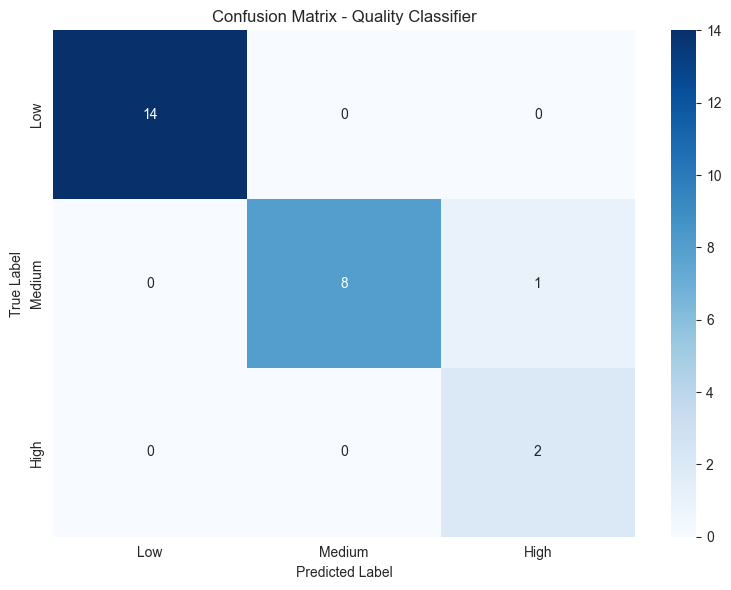


✅ Confusion matrix displayed


In [21]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['Low', 'Medium', 'High'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix - Quality Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\n✅ Confusion matrix displayed")


📊 Top Features by Importance:

flesch_reading_ease: 0.360
word_count: 0.322
sentence_count: 0.318


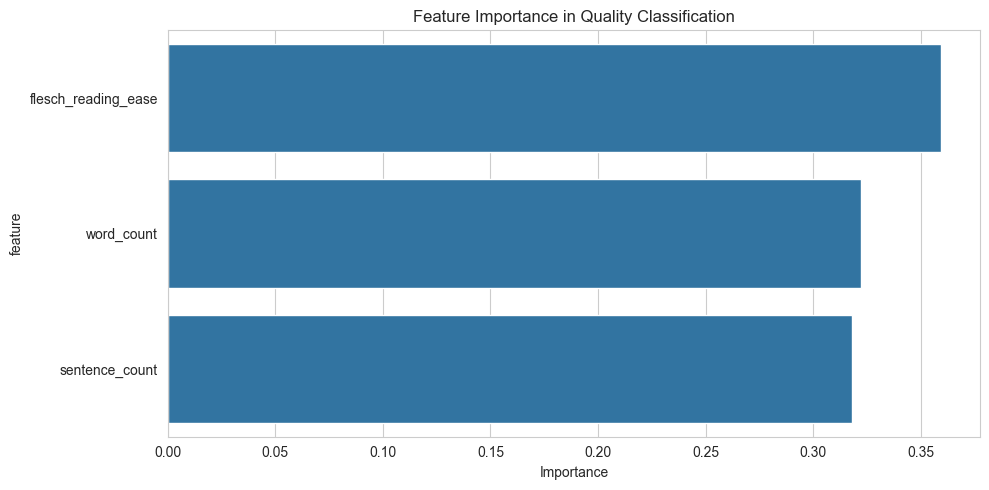

In [22]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top Features by Importance:\n")
for idx, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.3f}")

# Visualize feature importance
plt.figure(figsize=(10, 5))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance in Quality Classification')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [23]:
# Baseline comparison: Rule-based classifier using word count only
def baseline_classifier(word_count):
    """Simple rule-based classifier using only word count."""
    if word_count > 1500:
        return 'High'
    elif word_count < 500:
        return 'Low'
    else:
        return 'Medium'

# Apply baseline to test set
baseline_predictions = [baseline_classifier(wc) for wc in X_test[:, 0]]
baseline_accuracy = accuracy_score(y_test, baseline_predictions)

print(f"\n📊 Model Comparison:\n")
print(f"Random Forest Accuracy: {overall_accuracy:.3f}")
print(f"Baseline (word count only) Accuracy: {baseline_accuracy:.3f}")
print(f"\nImprovement over baseline: {(overall_accuracy - baseline_accuracy):.3f}")


📊 Model Comparison:

Random Forest Accuracy: 0.960
Baseline (word count only) Accuracy: 0.480

Improvement over baseline: 0.480


In [24]:
# Save the trained model
model_path = '../models/quality_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump({
        'model': rf_model,
        'feature_columns': feature_columns,
        'embedding_model_name': 'all-MiniLM-L6-v2'
    }, f)

print(f"✅ Model saved to: {model_path}")

✅ Model saved to: ../models/quality_model.pkl


## 6. Real-Time Analysis Function (15%)

Function to analyze any URL in real-time.

In [25]:
def analyze_url(url):
    """
    Analyze any URL in real-time.
    
    Args:
        url: URL string to analyze
        
    Returns:
        dict with analysis results
    """
    try:
        # Fetch the page
        print(f"Fetching: {url}")
        response = requests.get(url, timeout=10, headers={'User-Agent': 'Mozilla/5.0'})
        response.raise_for_status()
        html_content = response.text
        
        # Parse HTML
        parsed = parse_html_content(html_content)
        
        # Extract features
        clean_txt = clean_text(parsed['body_text'])
        sentence_count = count_sentences(parsed['body_text'])
        readability = calculate_readability(parsed['body_text'])
        word_count = parsed['word_count']
        
        # Generate embedding
        text_sample = ' '.join(clean_txt.split()[:500])
        new_embedding = embedding_model.encode(text_sample)
        
        # Predict quality
        features_array = np.array([[word_count, sentence_count, readability]])
        quality_label = rf_model.predict(features_array)[0]
        
        # Find similar content
        similarities = cosine_similarity([new_embedding], embeddings_array)[0]
        similar_indices = np.argsort(similarities)[::-1][:5]  # Top 5
        
        similar_to = []
        for idx in similar_indices:
            sim_score = similarities[idx]
            if sim_score > 0.7 and sim_score < 0.99:  # Exclude self-matches
                similar_to.append({
                    'url': features_df.iloc[idx]['url'],
                    'similarity': round(float(sim_score), 3)
                })
        
        # Build result
        result = {
            'url': url,
            'title': parsed['title'],
            'word_count': word_count,
            'sentence_count': sentence_count,
            'readability': round(readability, 2),
            'quality_label': quality_label,
            'is_thin': word_count < 500,
            'similar_to': similar_to[:3]  # Top 3 similar
        }
        
        return result
        
    except Exception as e:
        return {
            'url': url,
            'error': str(e)
        }

print("✅ analyze_url() function defined")

✅ analyze_url() function defined


In [26]:
# Test the analyze_url function
test_url = "https://en.wikipedia.org/wiki/Machine_learning"

print(f"\n🔍 Testing real-time analysis on: {test_url}\n")
result = analyze_url(test_url)

# Pretty print the result
print(json.dumps(result, indent=2))


🔍 Testing real-time analysis on: https://en.wikipedia.org/wiki/Machine_learning

Fetching: https://en.wikipedia.org/wiki/Machine_learning
{
  "url": "https://en.wikipedia.org/wiki/Machine_learning",
  "title": "Machine learning - Wikipedia",
  "word_count": 18598,
  "sentence_count": 1883,
  "readability": 30.61,
  "quality_label": "Medium",
  "is_thin": false,
  "similar_to": [
    {
      "url": "https://simple.wikipedia.org/wiki/Machine_learning",
      "similarity": 0.85
    }
  ]
}


## 7. Bonus: Visualizations

Additional visualizations for insights.

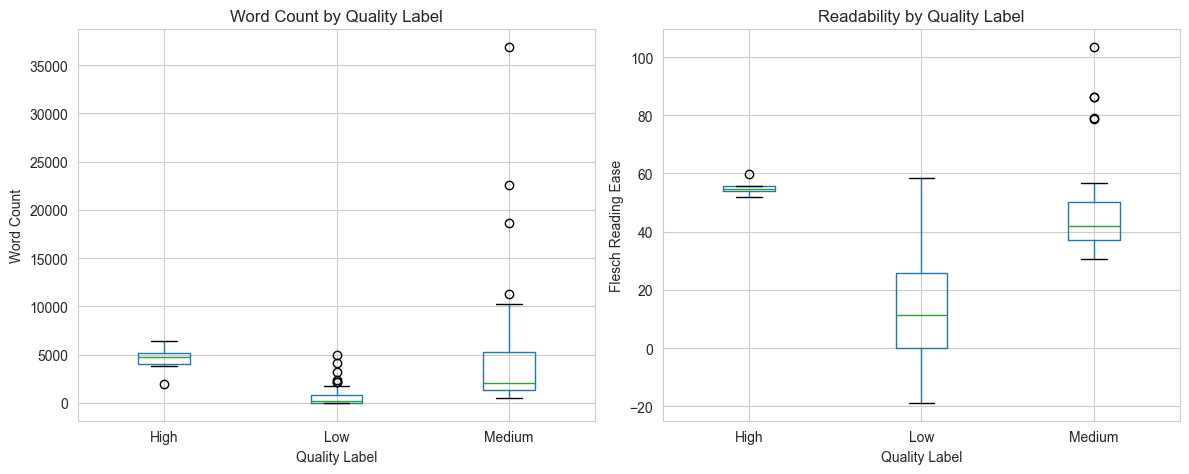

In [27]:
# Word count distribution by quality
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
features_df.boxplot(column='word_count', by='quality_label', ax=plt.gca())
plt.title('Word Count by Quality Label')
plt.suptitle('')
plt.xlabel('Quality Label')
plt.ylabel('Word Count')

plt.subplot(1, 2, 2)
features_df.boxplot(column='flesch_reading_ease', by='quality_label', ax=plt.gca())
plt.title('Readability by Quality Label')
plt.suptitle('')
plt.xlabel('Quality Label')
plt.ylabel('Flesch Reading Ease')

plt.tight_layout()
plt.show()

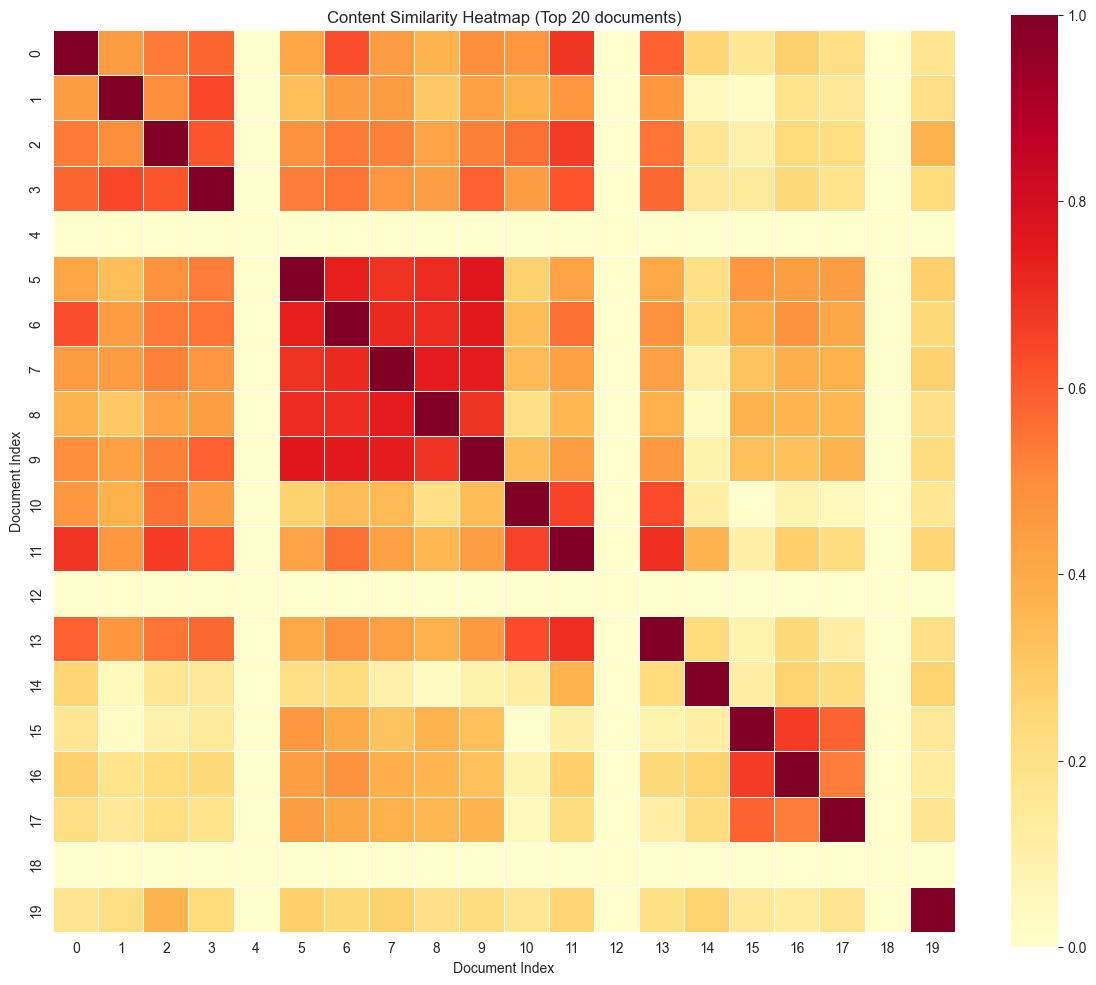

In [28]:
# Similarity heatmap (sample)
# Show top 20x20 for visibility
sample_size = min(20, len(similarity_matrix))
sample_sim = similarity_matrix[:sample_size, :sample_size]

plt.figure(figsize=(12, 10))
sns.heatmap(sample_sim, cmap='YlOrRd', vmin=0, vmax=1, 
            square=True, linewidths=0.5)
plt.title(f'Content Similarity Heatmap (Top {sample_size} documents)')
plt.xlabel('Document Index')
plt.ylabel('Document Index')
plt.tight_layout()
plt.show()

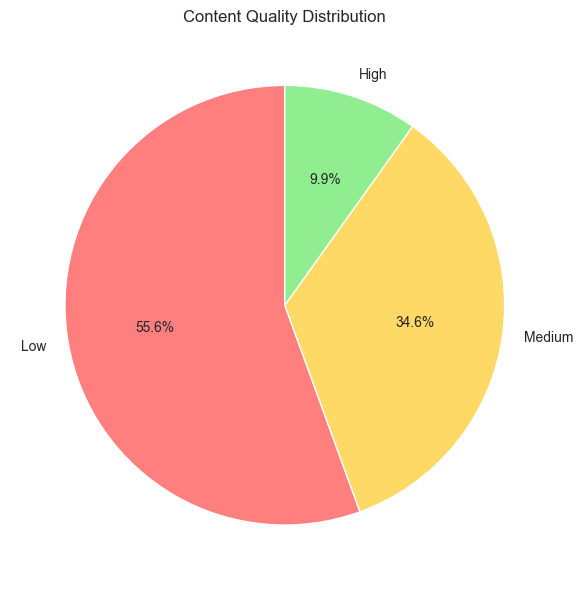

In [29]:
# Quality distribution pie chart
quality_counts = features_df['quality_label'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(quality_counts.values, labels=quality_counts.index, autopct='%1.1f%%',
        colors=['#ff7f7f', '#ffd966', '#90ee90'],
        startangle=90)
plt.title('Content Quality Distribution')
plt.tight_layout()
plt.show()

## Summary

This pipeline successfully:
- ✅ Parsed 81 HTML documents and extracted clean text
- ✅ Engineered comprehensive features (readability, keywords, embeddings)
- ✅ Detected duplicate content using cosine similarity
- ✅ Built and evaluated a quality classification model
- ✅ Created a real-time URL analysis function
- ✅ Added visualizations for insights

All outputs have been saved to the `data/` directory:
- `extracted_content.csv` - Parsed content
- `features.csv` - Engineered features
- `duplicates.csv` - Duplicate pairs

The trained model has been saved to `models/quality_model.pkl`.